In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [51]:
test.columns

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked',
       'Title', 'Fsize'],
      dtype='object')

In [78]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          695
Embarked         2
Title            0
dtype: int64

In [79]:
test.isnull().sum()

PassengerId      0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          332
Embarked         0
Title            0
dtype: int64

In [4]:
def barchart(item):
    surv = train[train["Survived"] == 1][item].value_counts()
    dead = train[train["Survived"] == 0][item].value_counts()
    gg = pd.DataFrame({"Survived":surv, "Dead":dead})
    gg.plot(kind="bar", stacked=0, title=i)

Insights:

-**1st class** is more likely survived & **3rd class** more likely dead, **2nd class** unknown.

-**Females** more likely survived, **Males** more likely dead.

-**No Sibling** more likely dead.

-**S port** more likely dead, else unkown.

# Feature engineering

In [5]:
train_test = [train, test]

## Change Sex

In [6]:
#Change sex
dict_sex = {"female": 0, "male":1}
for sets in train_test:
    sets["Sex"] = sets.Sex.map(dict_sex)

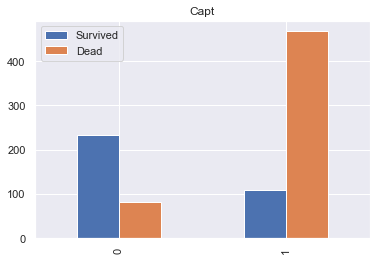

In [94]:
barchart("Sex")

## Change Embarked ports to numbers

In [90]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [7]:
# S = 0
# C = 1
# Q = 2
dict_embark = {"S":0, "C":1, "Q":2}
for sets in train_test:
    sets["Embarked"] = sets.Embarked.map(dict_embark)

In [8]:
train.Embarked.fillna(train["Embarked"].median(), inplace=True)

## Change Names

In [9]:
for sets in train_test:
    sets["Title"] = sets["Name"].str.extract("([\w]+)[.]") #extract the title from the name
train.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Lady          1
Mme           1
Don           1
Countess      1
Ms            1
Capt          1
Jonkheer      1
Sir           1
Name: Title, dtype: int64

Mr = 0
Miss = 1
Mrs = 2
Others = 3

In [10]:
dict_ = {"Mr":0, "Miss":1, "Mrs":2}
n = ['Master', 'Dr', 'Rev', 'Col', 'Major', 'Mlle', 'Lady', 'Jonkheer',
       'Sir', 'Mme', 'Ms', 'Don', 'Countess', 'Capt']
for i in n:
    dict_[i] = 3

In [11]:
for sets in train_test:
    sets["Title"] = sets["Title"].map(dict_)
test["Title"] = test["Title"].fillna(value=0) #as to deal with na's
train["Title"] = train["Title"].fillna(value=0)

In [12]:
train.drop("Name", axis=1, inplace=True)
test.drop("Name", axis=1, inplace=True)

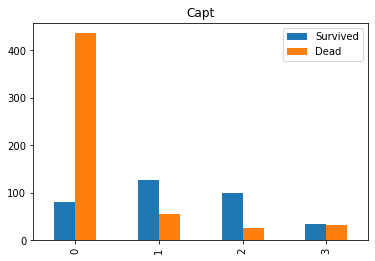

In [10]:
barchart("Title")

## Deal with Age NaNs

In [13]:
train.Age.fillna(train.groupby("Title")["Age"].transform("median"), inplace=True)
test.Age.fillna(test.groupby("Title")["Age"].transform("median"), inplace=True)

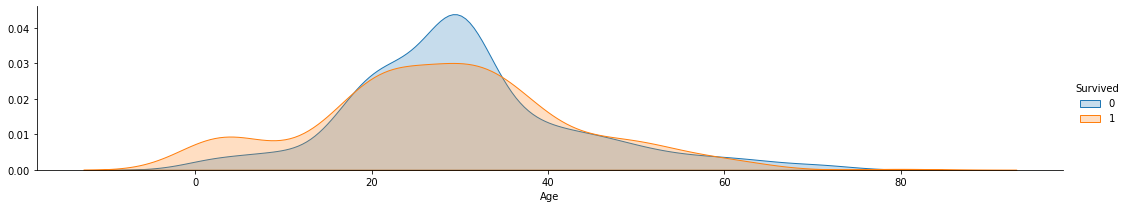

In [12]:
plot = sns.FacetGrid(train, hue="Survived", aspect=5)
plot.map(sns.kdeplot, "Age", shade=True)
plot.add_legend()

In [14]:
#Lets group ages
for sets in train_test:
    sets.loc[sets.Age <= 15, "Age"] = 0
    sets.loc[(15 < sets.Age) & (sets.Age <= 30), "Age"] = 1
    sets.loc[(30 < sets.Age) & (sets.Age <= 45), "Age"] = 2
    sets.loc[sets.Age > 45, "Age"] = 3
#May want to further analyse the limits for each group from the chart above

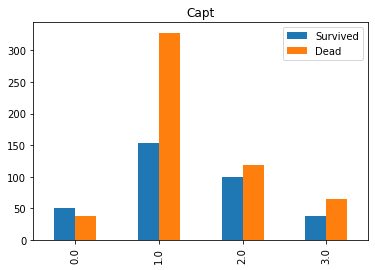

In [14]:
barchart("Age")

# Fare

In [15]:
# Fix test fare na
test.Fare.fillna(train.groupby("Pclass")["Fare"].transform("median"), inplace=True)

(29.0, 512.3292)

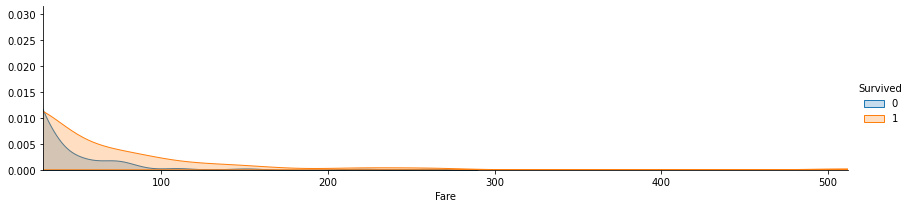

In [16]:
plot_fare = sns.FacetGrid(train, hue="Survived", aspect=4)
plot_fare.map(sns.kdeplot, "Fare", shade=True)
plot_fare.set(xlim=(0, train.Fare.max()))
plot_fare.add_legend()
plt.xlim(29,)

In [17]:
for sets in train_test:
    sets.loc[sets.Fare <= 15, "Fare"] = 0
    sets.loc[(15 < sets.Fare) & (sets.Fare <= 29), "Fare"] = 1
    sets.loc[(29 < sets.Fare) & (sets.Fare <= 45), "Fare"] = 2
    sets.loc[sets.Fare > 45, "Fare"] = 3

# Change cabin names into categories

In [37]:
train.Cabin.head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [18]:
for sets in train_test:
    sets["Cabin"] = sets.Cabin.str.extract("^([A-Z])[0-9]")

In [19]:
cabins = pd.DataFrame([train[train.Pclass == 1]["Cabin"].value_counts(),
                       train[train.Pclass == 2]["Cabin"].value_counts(),
                       train[train.Pclass == 3]["Cabin"].value_counts()
])
cabins.index = ["1st", "2nd", "3rd"]

<AxesSubplot:>

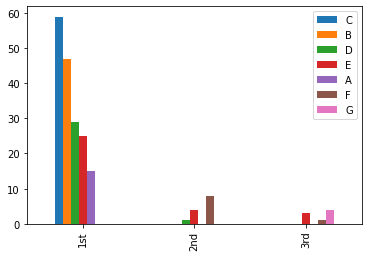

In [72]:
cabins.plot(kind="bar")

In [20]:
cab = {"A":0, "B":0.4, "C":0.8, "D":1.2, "E":1.6, "F":2, "G":2.4}

In [21]:
for sets in train_test:
    sets.Cabin = sets.Cabin.map(cab)

In [22]:
test.Cabin.fillna(test.groupby("Pclass")["Cabin"].transform("median"), inplace=True)
train.Cabin.fillna(train.groupby("Pclass")["Cabin"].transform("median"), inplace=True)

In [106]:
test.Cabin.value_counts()

0.8    35
0.4    18
1.2    12
1.6     9
0.0     7
2.0     4
2.4     1
Name: Cabin, dtype: int64

## Family Size 

In [23]:
for sets in train_test:
    sets["Fsize"] = sets.SibSp + sets.Parch + 1

In [110]:
train.Fsize.value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: Fsize, dtype: int64

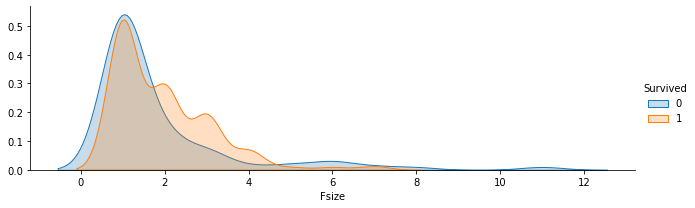

In [24]:
plot_family = sns.FacetGrid(train, hue="Survived", aspect=3)
plot_family.map(sns.kdeplot, "Fsize", shade=True)
plot_family.add_legend()

In [25]:
dict_fam = {1:0,2:0.4,3:0.8,4:1.2,5:1.6,6:2,7:2.4,8:2.8,9:3.2,10:3.6,11:4}
for sets in train_test:
    sets.Fsize = sets.Fsize.map(dict_fam)

In [26]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Title          0
Fsize          0
dtype: int64

In [27]:
n_drop = ["Ticket", "SibSp", "Parch"]
train = train.drop(n_drop, axis=1)
test = test.drop(n_drop, axis=1)
train = train.drop("PassengerId", axis=1)

In [28]:
train_data = train.drop("Survived", axis=1)
target = train.Survived

In [29]:
train_data.head(10)

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Fsize
0,3,1,1.0,0.0,2.2,0.0,0,0.4
1,1,0,2.0,3.0,0.8,1.0,2,0.4
2,3,0,1.0,0.0,2.2,0.0,1,0.0
3,1,0,2.0,3.0,0.8,0.0,2,0.4
4,3,1,2.0,0.0,2.2,0.0,0,0.0
5,3,1,1.0,0.0,2.2,2.0,0,0.0
6,1,1,3.0,3.0,1.6,0.0,0,0.0
7,3,1,0.0,1.0,2.2,0.0,3,1.6
8,3,0,1.0,0.0,2.2,0.0,2,0.8
9,2,0,0.0,2.0,2.0,1.0,2,0.4


# MODEL Selection

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import numpy as np

## Kneighboors

In [44]:
k = KFold(n_splits=10, shuffle=True, random_state=0)
model_kn = KNeighborsClassifier(n_neighbors=10)
acc = cross_val_score(model_kn, train_data.values, target.values, cv=k, n_jobs=1, scoring="accuracy")

In [45]:
k_mean = sum([i/len(acc) for i in acc])
k_mean

0.8215980024968789

### SVC

In [46]:
model_svc = SVC()
acc = cross_val_score(model_svc, train_data.values, target.values, cv=k, n_jobs=1, scoring="accuracy")

In [47]:
svc_mean = sum([i/len(acc) for i in acc])
svc_mean

0.8294132334581772

### Svc is better performing than kneighboors, so will use that

In [49]:
model_svc.fit(train_data, target)
predictions = model_svc.predict(test.drop("PassengerId", axis=1))

In [52]:
result = pd.DataFrame({"PassengerId":test.PassengerId, "Survived":predictions})

In [55]:
result.to_csv("submission.csv", index=False)